In [28]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [88]:
df_test = pd.read_csv('test.csv', index_col=0)
df_train = pd.read_csv('train.csv', index_col=0)

In [3]:
df_train

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,,,,,,,,,
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8
...,...,...,...,...,...,...,...,...,...
74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10
74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6
74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10


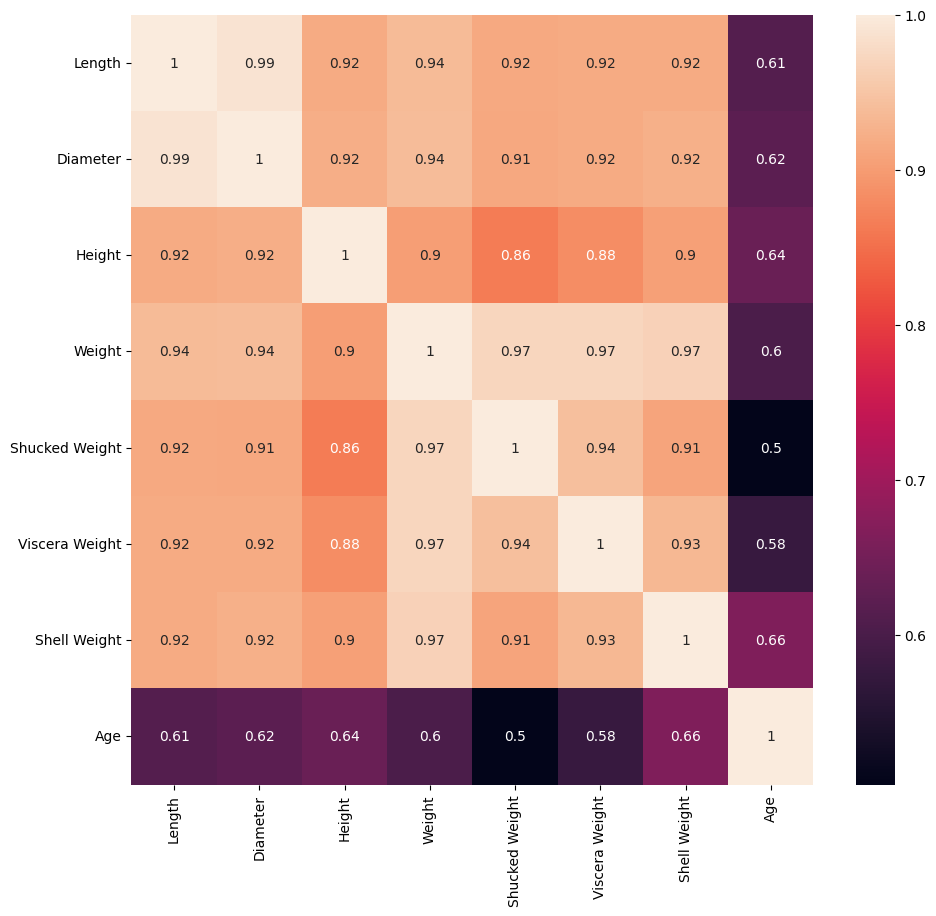

In [31]:
train = df_train.select_dtypes(exclude='object')

plt.figure(figsize=(11, 10))
sns.heatmap(train.corr(), annot=True)
plt.show()

In [34]:
print(len(df_train[df_train['Sex'] == 'I']) / len(df_train))
print(len(df_train[df_train['Sex'] == 'M']) / len(df_train))
print(len(df_train[df_train['Sex'] == 'F']) / len(df_train))


0.32352027656615034
0.36574793048034465
0.310731792953505


In [40]:
unknown_data = df_train[df_train['Sex'] == 'I']
male_data = df_train[df_train['Sex'] == 'M']
female_data = df_train[df_train['Sex'] == 'F']

In [43]:
for col in ['Diameter', 'Height', 'Weight']:
    print(np.mean(unknown_data[col]))
    print(np.mean(male_data[col]))
    print(np.mean(female_data[col]))
    print('.......................')

0.7988422013399006
1.1192539875941518
1.1479017275097783
.......................
0.26340912885586676
0.3832201997489292
0.39490420469361137
.......................
11.653656060228741
28.22712481639806
29.900417874808884
.......................


Известно, что женские особи чуть крупнее мужских и в датасете это видно. Кроме того вероятно I == Infant судя по более малым размерам, проверим наше предположение в ячейке ниже

In [44]:
print(np.mean(unknown_data['Age']))
print(np.mean(female_data['Age']))
print(np.mean(male_data['Age']))

7.59907333973369
11.341547153411561
10.89595333037956


In [49]:
set(df_test["Sex"].isna())

{False}

Идея: разбить на 3 подвыборки и тренировать на них, тк большая кореляция среди данных - добавить L2 регуляризацию

In [89]:
y = df_train['Age']
X = df_train

X['Length_Diameter_Ratio'] = X['Length'] / X['Diameter']
X['Shucked_Weight_Ratio'] = X['Shucked Weight'] / X['Weight']
X['Viscera_Weight_Ratio'] = X['Viscera Weight'] / X['Weight']
X['Shell_Weight_Ratio'] = X['Shell Weight'] / X['Weight']
X['Shucked_Viscera_Ratio'] = X['Shucked Weight'] / X['Viscera Weight']
X['Shucked_Shell_Ratio'] = X['Shucked Weight'] / X['Shell Weight']
X['Viscera_Shell_Ratio'] = X['Viscera Weight'] / X['Shell Weight']

for col in X.columns:
    if (col != 'Sex') and (col != 'Age'):
        X[f'{col}_squared'] = X[col] ** 2
        X[f'{col}_cubed'] = X[col] ** 3
        X[f'{col}_log'] = np.log1p(X[col])
        X[f'{col}_sqrt'] = X[col] ** 0.5

In [139]:
FX = X[X['Sex'] == 'F'].drop(columns=['Age'])
MX = X[X['Sex'] == 'M'].drop(columns=['Age'])
IX = X[X['Sex'] == 'I'].drop(columns=['Age'])
CX = X[X['Sex'] != 'I'].drop(columns=['Age'])

Fy = df_train[df_train['Sex'] == 'F']['Age']
My = df_train[df_train['Sex'] == 'M']['Age']
Iy = df_train[df_train['Sex'] == 'I']['Age']
Cy = df_train[df_train['Sex'] != 'I']['Age']



FX_train, FX_test, Fy_train, Fy_test = train_test_split(FX, Fy, test_size=0.3, random_state=42, shuffle=True)
MX_train, MX_test, My_train, My_test = train_test_split(MX, My, test_size=0.3, random_state=42, shuffle=True)
IX_train, IX_test, Iy_train, Iy_test = train_test_split(IX, Iy, test_size=0.3, random_state=42, shuffle=True)

In [91]:
FX_train.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Length_Diameter_Ratio,Shucked_Weight_Ratio,Viscera_Weight_Ratio,...,Shucked_Viscera_Ratio_log,Shucked_Viscera_Ratio_sqrt,Shucked_Shell_Ratio_squared,Shucked_Shell_Ratio_cubed,Shucked_Shell_Ratio_log,Shucked_Shell_Ratio_sqrt,Viscera_Shell_Ratio_squared,Viscera_Shell_Ratio_cubed,Viscera_Shell_Ratio_log,Viscera_Shell_Ratio_sqrt
count,16107.000000,16107.000000,16107.000000,16107.000000,16107.000000,16107.000000,16107.000000,16107.000000,16107.000000,16107.000000,...,16107.000000,16107.000000,16107.000000,16107.000000,16107.000000,16107.000000,16107.000000,16107.000000,16107.000000,16107.000000
mean,1.464562,1.147372,0.394730,29.839499,12.752923,6.481142,8.566971,1.278289,0.426164,0.217916,...,1.086866,1.403394,2.340196,3.793800,0.908675,1.218149,0.598375,0.483381,0.563822,0.869801
std,0.176092,0.145348,0.065433,10.209493,4.687741,2.284438,2.896049,0.041066,0.049634,0.025694,...,0.111578,0.118671,0.950422,2.397040,0.121578,0.124421,0.209508,0.269476,0.074414,0.075511
min,0.587500,0.400000,0.037500,1.360776,0.510291,0.326019,0.425243,0.976744,0.211234,0.097780,...,0.492283,0.797525,0.310518,0.173033,0.442916,0.746486,0.082656,0.023764,0.252702,0.536190
25%,1.375000,1.062500,0.362500,23.048143,9.482908,4.861939,6.775531,1.254717,0.395225,0.201538,...,1.012297,1.323600,1.668985,2.156148,0.829378,1.136614,0.453301,0.305197,0.514783,0.820534
50%,1.487500,1.175000,0.400000,29.908722,12.743100,6.392812,8.504850,1.277778,0.428983,0.217172,...,1.084890,1.399684,2.218709,3.304840,0.912095,1.220464,0.577016,0.438310,0.565095,0.871559
75%,1.587500,1.250000,0.437500,36.230661,15.705623,7.980384,10.205820,1.300000,0.459373,0.234006,...,1.159197,1.478977,2.869050,4.859676,0.990963,1.301471,0.714648,0.604141,0.612679,0.919439
max,1.950000,1.612500,2.825000,72.432973,35.139205,17.293195,28.491248,1.671233,0.696751,0.431111,...,1.730844,2.155323,14.273905,53.927986,1.564039,1.943729,4.417548,9.284787,1.131981,1.449757


In [133]:
cat_cols = ['Sex']
num_cols = list(set(FX.columns) - set(cat_cols))

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ('scaling', StandardScaler(), num_cols)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', XGBRegressor(random_state=42))
])

In [103]:
'Age' in num_cols

False

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

Fmodel = pipeline.fit(FX_train, Fy_train)
Mmodel = pipeline.fit(MX_train, My_train)
Imodel = pipeline.fit(IX_train, Iy_train)
# My_train

In [135]:
Fy_pred = Fmodel.predict(FX_test)
print(f"Test MAE = {mean_absolute_error(Fy_test, Fy_pred):.4f}, MAPE = {mean_absolute_percentage_error(Fy_test, Fy_pred):.4f}")

My_pred = Fmodel.predict(MX_test)
print(f"Test MAE = {mean_absolute_error(My_test, My_pred):.4f}, MAPE = {mean_absolute_percentage_error(My_test, My_pred):.4f}")

Iy_pred = Fmodel.predict(IX_test)
print(f"Test MAE = {mean_absolute_error(Iy_test, Iy_pred):.4f}, MAPE = {mean_absolute_percentage_error(Iy_test, Iy_pred):.4f}")



Test MAE = 1.9887, MAPE = 0.1702
Test MAE = 1.8224, MAPE = 0.1612
Test MAE = 0.9617, MAPE = 0.1275


In [141]:
Fmodel_final = pipeline.fit(FX, Fy)
Mmodel_final = pipeline.fit(MX, My)
Imodel_final = pipeline.fit(IX, Iy)
Cmodel_final = pipeline.fit(CX, Cy)
X_pred = pd.read_csv('test.csv')

X_pred['Length_Diameter_Ratio'] = X_pred['Length'] / X_pred['Diameter']
X_pred['Shucked_Weight_Ratio'] = X_pred['Shucked Weight'] / X_pred['Weight']
X_pred['Viscera_Weight_Ratio'] = X_pred['Viscera Weight'] / X_pred['Weight']
X_pred['Shell_Weight_Ratio'] = X_pred['Shell Weight'] / X_pred['Weight']
X_pred['Shucked_Viscera_Ratio'] = X_pred['Shucked Weight'] / X_pred['Viscera Weight']
X_pred['Shucked_Shell_Ratio'] = X_pred['Shucked Weight'] / X_pred['Shell Weight']
X_pred['Viscera_Shell_Ratio'] = X_pred['Viscera Weight'] / X_pred['Shell Weight']

for col in X_pred.columns:
    if (col != 'Sex') and (col != 'Age'):
        X_pred[f'{col}_squared'] = X_pred[col] ** 2
        X_pred[f'{col}_cubed'] = X_pred[col] ** 3
        X_pred[f'{col}_log'] = np.log1p(X_pred[col])
        X_pred[f'{col}_sqrt'] = X_pred[col] ** 0.5

# Fy_pred_final = Fmodel_final.predict(X_pred[X_pred['Sex'] == 'F'])#, X_pred[X_pred['Sex'] == 'F']['id']
# My_pred_final = Mmodel_final.predict(X_pred[X_pred['Sex'] == 'M'])#, X_pred[X_pred['Sex'] == 'M']['id']
Iy_pred_final = Imodel_final.predict(X_pred[X_pred['Sex'] == 'I'])#, X_pred[X_pred['Sex'] == 'I']['id']
Cy_pred_final = Cmodel_final.predict(X_pred[X_pred['Sex'] != 'I'])

y = np.empty(X_pred.shape[0])
y[X_pred[X_pred['Sex'] == 'I'].index] = Iy_pred_final
# y[X_pred[X_pred['Sex'] == 'F'].index] = Fy_pred_final
# y[X_pred[X_pred['Sex'] == 'M'].index] = My_pred_final
y[X_pred[X_pred['Sex'] != 'I'].index] = Cy_pred_final

ans = pd.DataFrame({'id': X_pred['id'], 'yield': y})
ans
# X_pred[X_pred['Sex'] == 'F'].index

,id,yield
0,74051,9.488162
1,74052,8.143178
2,74053,10.604278
3,74054,10.292688
4,74055,8.275021
...,...,...
49363,123414,10.762555
49364,123415,9.684465
49365,123416,12.726539
49366,123417,10.426199


In [143]:
ans.to_csv('submission.csv', index=False)